## Setup Paths

In [2]:
import numpy as np
import os

In [1]:
CUSTOM_MODEL_NAME = 'consumzy_dataset_v2'
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'


In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow', 'scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow', 'models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace', 'annotations_2'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace', 'images_2'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace', 'models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace', 'pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME),
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'export'),
    'TFJS_PATH': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'tfjsexport'),
    'TFLITE_PATH': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'tfliteexport'),
    'PROTOC_PATH': os.path.join('Tensorflow', 'protoc'),
}


In [73]:
import time
import calendar

In [75]:
current_GMT = time.gmtime()

time_stamp = calendar.timegm(current_GMT)
print(type(time_stamp))

<class 'int'>


In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [ ]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}


In [ ]:
files

## Download Model Pretained

In [ ]:
if os.name == 'nt':
    !pip install wget


In [ ]:
import wget


In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection
if os.name == 'posix':
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

if os.name == 'nt':
    url = "https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + \
        os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))
    !cd Tensorflow/models/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/models/research/slim && pip install -e .


In [ ]:
VERIFICATION_SCRIPT = os.path.join(
    paths['APIMODEL_PATH'],'models', 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}


In [5]:
import tensorflow as tf

In [ ]:
if os.name == 'posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}


## Create Label Map


In [6]:
labels = [
    {'name': '0', 'id': 1},
    {'name': '1', 'id': 2},
    {'name': '2', 'id': 4},
    {'name': '3', 'id': 5},
    {'name': '4', 'id': 6},
    {'name': '5', 'id': 7},
    {'name': '6', 'id': 8},
    {'name': '7', 'id': 9},
    {'name': '8', 'id': 10},
    {'name': '9', 'id': 11},
    {'name': '10', 'id': 3}
]


## Create TF Record

This task handle using robolow

## Copy Config

In [ ]:
if os.name == 'posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

In [7]:
import tensorflow as tf
from google.protobuf import text_format
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2


In [8]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])


In [ ]:
config

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)


In [ ]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 2
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(
    paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path = files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [
    os.path.join(paths['ANNOTATION_PATH'], 'train.tfrecord')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [
    os.path.join(paths['ANNOTATION_PATH'], 'test.tfrecord')]


In [ ]:
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:
    f.write(config_text)


## Training

In [ ]:
TRAINING_SCRIPT = os.path.join(
    paths['APIMODEL_PATH'], 'models','research', 'object_detection', 'model_main_tf2.py')


In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=500".format(
    TRAINING_SCRIPT, paths['CHECKPOINT_PATH'], files['PIPELINE_CONFIG'])

In [ ]:
print(command)


In [ ]:
!{command}

## Evaluate

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(
    TRAINING_SCRIPT, paths['CHECKPOINT_PATH'], files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])
print(command)


In [ ]:
!{command}


In [ ]:
https: // github.com/tensorflow/models/issues/4671


## Load Models

In [10]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util


c:\ProgramData\Anaconda3\envs\consumzy\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\ProgramData\Anaconda3\envs\consumzy\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.


In [11]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(
    model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-6')).expect_partial()


@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections


## Detect Image

In [20]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [12]:
category_index = label_map_util.create_category_index_from_labelmap(
    files['LABELMAP'])


In [67]:
import shutil

In [13]:
category_index

{1: {'id': 1, 'name': 'Alpukat'},
 2: {'id': 2, 'name': 'Buah Naga'},
 4: {'id': 4, 'name': 'Jambu Biji'},
 5: {'id': 5, 'name': 'Kedondong'},
 6: {'id': 6, 'name': 'Kesemek'},
 7: {'id': 7, 'name': 'Kiwi'},
 8: {'id': 8, 'name': 'Lemon'},
 9: {'id': 9, 'name': 'Manggis'},
 10: {'id': 10, 'name': 'Markisa'},
 11: {'id': 11, 'name': 'Salak'},
 3: {'id': 3, 'name': 'Sawo'}}

In [14]:
import random

In [ ]:
random.choice(os.listdir(os.path.join(paths["IMAGE_PATH"],'test')))

In [30]:
IMAGE_PATH = os.path.join(
    paths['IMAGE_PATH'], 'test', random.choice(
        os.listdir(os.path.join(paths["IMAGE_PATH"], 'test'))))


In [31]:
IMAGE_PATH

'Tensorflow\\workspace\\images_2\\test\\Alpukat_96_jpg.rf.ce0e6f97d5702798aaf4f796aace293a.jpg'

array([[[191, 199, 198],
        [191, 199, 198],
        [191, 199, 198],
        ...,
        [198, 203, 204],
        [198, 203, 204],
        [198, 203, 204]],

       [[191, 199, 198],
        [191, 199, 198],
        [191, 199, 198],
        ...,
        [198, 203, 204],
        [198, 203, 204],
        [198, 203, 204]],

       [[191, 199, 198],
        [191, 199, 198],
        [191, 199, 198],
        ...,
        [198, 203, 204],
        [198, 203, 204],
        [198, 203, 204]],

       ...,

       [[202, 207, 208],
        [202, 207, 208],
        [202, 207, 208],
        ...,
        [209, 217, 216],
        [209, 217, 216],
        [209, 217, 216]],

       [[202, 207, 208],
        [202, 207, 208],
        [202, 207, 208],
        ...,
        [209, 217, 216],
        [209, 217, 216],
        [209, 217, 216]],

       [[202, 207, 208],
        [202, 207, 208],
        [202, 207, 208],
        ...,
        [209, 217, 216],
        [209, 217, 216],
        [209, 217, 216]]

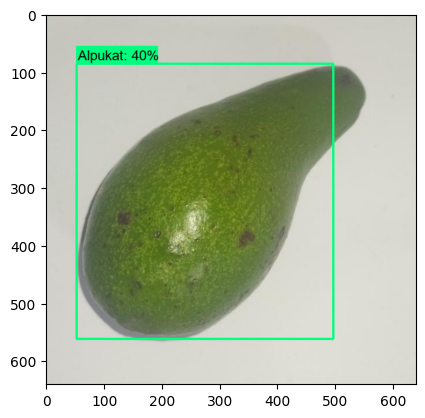

In [68]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(
    np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'],
    detections['detection_classes']+label_id_offset,
    detections['detection_scores'],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=5,
    min_score_thresh=.38,
    agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
cv2.imwrite('detect.jpg',image_np_with_detections)
plt.show()


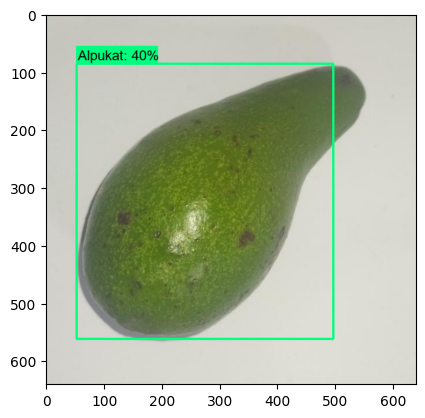

In [63]:
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))


In [64]:
image_np_with_detections


array([[[191, 199, 198],
        [191, 199, 198],
        [191, 199, 198],
        ...,
        [198, 203, 204],
        [198, 203, 204],
        [198, 203, 204]],

       [[191, 199, 198],
        [191, 199, 198],
        [191, 199, 198],
        ...,
        [198, 203, 204],
        [198, 203, 204],
        [198, 203, 204]],

       [[191, 199, 198],
        [191, 199, 198],
        [191, 199, 198],
        ...,
        [198, 203, 204],
        [198, 203, 204],
        [198, 203, 204]],

       ...,

       [[202, 207, 208],
        [202, 207, 208],
        [202, 207, 208],
        ...,
        [209, 217, 216],
        [209, 217, 216],
        [209, 217, 216]],

       [[202, 207, 208],
        [202, 207, 208],
        [202, 207, 208],
        ...,
        [209, 217, 216],
        [209, 217, 216],
        [209, 217, 216]],

       [[202, 207, 208],
        [202, 207, 208],
        [202, 207, 208],
        ...,
        [209, 217, 216],
        [209, 217, 216],
        [209, 217, 216]]

In [51]:
detections['detection_boxes'][0]*640



array([ 86.984955,  52.680225, 561.82666 , 497.3376  ], dtype=float32)

In [58]:
detections['detection_classes'][0]+label_id_offset
print(category_index[detections['detection_classes'][0]+label_id_offset])



{'id': 1, 'name': 'Alpukat'}


In [65]:
detections['detection_scores'][0]

0.39651218

## Frozen Graph

In [ ]:
FREEZE_SCRIPT = os.path.join(
    paths['APIMODEL_PATH'], 'models','research', 'object_detection', 'exporter_main_v2.py ')


In [ ]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(
    FREEZE_SCRIPT, files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])
print(command)


In [ ]:
!{command}


## TF Lite Convert

In [ ]:
TFLITE_SCRIPT = os.path.join(
    paths['APIMODEL_PATH'],'models', 'research', 'object_detection', 'export_tflite_graph_tf2.py ')


In [ ]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(
    TFLITE_SCRIPT, files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])
print(command)


In [ ]:
!{command}

In [ ]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(
    paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')


In [ ]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,640,640,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )


In [ ]:
print(command)


In [ ]:
!{command}


In [ ]:
interpreter = tf.lite.Interpreter(
    model_path=TFLITE_MODEL)


In [ ]:
interpreter.allocate_tensors()  # Needed before execution!


In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [ ]:
input_details

In [ ]:
output_details

In [ ]:
from PIL import Image
from numpy import asarray

In [ ]:
image = cv2.imread(IMAGE_PATH)

In [ ]:
img_arr= np.array(image)

In [ ]:
img_arr.shape

In [ ]:
data_q=tf.convert_to_tensor(np.expand_dims(img_arr, 0), dtype=tf.float32)


In [ ]:
data_q

In [ ]:
interpreter.set_tensor(input_details[0]['index'], data_q)
interpreter.invoke()
hasil = []
for i in range(4):
  hasil.append(interpreter.get_tensor(output_details[i]['index']))
for i in range(len(hasil)):
  print("output {}: {}".format(i, hasil[i]))

# image_np = np.array(img)

# input_tensor = tf.convert_to_tensor(
#     np.expand_dims(image_np, 0), dtype=tf.float32)
# detections = detect_fn(input_tensor)

# num_detections = int(detections.pop('num_detections'))
# detections = {key: value[0, :num_detections].numpy()
#               for key, value in detections.items()}


In [ ]:
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}


In [ ]:
def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(input=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  # results = []
  # # for i in range(count):
  # #   if scores[i] >= threshold:
  # #     result = {
  # #         'bounding_box': boxes[i],
  # #         'class_id': classes[i],
  # #         'score': scores[i]
  # #     }
  # detections = {key: value[0, :count].numpy()
  #               for key, value in detections.items()}
  #     results.append(result)
  return count, scores, classes,boxes
    

    


In [ ]:
count, score, classes, boxes = detect_objects(interpreter, data_q, 0.6)

In [ ]:
count

In [ ]:
score

In [ ]:
classes

In [ ]:
boxes

In [ ]:
COLORS = np.random.randint(0, 255, size=(len(category_index), 3), dtype=np.uint8)


In [ ]:
def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = cv2.imread(image_path)
  img = np.array(img)
  # img = tf.io.decode_image(img, channels=3)
  img = tf.convert_to_tensor(np.expand_dims(img, 0), dtype=tf.float32)
  original_image = img
  # resized_img = tf.image.resize(img, input_size)
  # resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.convert_to_tensor(
      np.expand_dims(img, 0), dtype=tf.float32)
  return resized_img


In [ ]:
def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8, xmin, xmax, ymin, ymax

In [ ]:
DETECTION_THRESHOLD = 0.6

im = Image.open(IMAGE_PATH)
im.thumbnail((640, 640), Image.ANTIALIAS)
im.save(IMAGE_PATH, 'jpeg')

# Load the TFLite model
# interpreter = tf.lite.Interpreter(model_path='glassist_model.tflite')
# interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image, xmin, xmax, ymin, ymax = run_odt_and_draw_results(
    IMAGE_PATH,
    interpreter,
    threshold=DETECTION_THRESHOLD
)


## TF JS

In [ ]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(
    os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])
print(command)


In [ ]:
!{command}
